<a href="https://colab.research.google.com/github/yyRegis/projeto-idc/blob/main/ScriptIDC3_k_NN_no_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Documentação do PyCaret:

- https://pycaret.gitbook.io/docs
- https://github.com/pycaret/pycaret/

In [1]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 386.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [2]:
# <> ------------------------------------------------------
# <> Se o pacote não tiver instalado
# <> executar o comando abaixo
%pip install pycaret --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# <> ------------------------------------------------------
# <> Verificando se o pacote foi instalado
%pip show pycaret

In [1]:
# <> -----------------------------------------------------
# Lendo as bibliotecas necessárias

# <> -----------------------------
# <> Bibliotecas dos algoritmos
from pycaret.classification import *
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.preprocessing import LabelEncoder
from pycaret.classification import setup, create_model, predict_model, tune_model
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats

# <> Bibliotecas de Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# <> Biliotecas para manipulação com dados
import pandas as pd


Forma 1 - Utilizando dados


In [2]:
url_data = '/content/student_admission_record_dirty.csv'  # Caminho do dataset
df= pd.read_csv(url_data)

In [3]:
# Remover colunas que não interessam--------
df.drop(columns=['Name','City'], inplace=True)

# Corrigir valores negativos
df.loc[df['Age'] < 0, 'Age'] = None
df.loc[df['Admission Test Score'] < 0, 'Admission Test Score'] = None
df.loc[df['High School Percentage'] < 0, 'High School Percentage'] = None

# Remover outliers extremos
percentile_99 = df[['Admission Test Score', 'High School Percentage']].quantile(0.99)
df = df[(df['Admission Test Score'] <= percentile_99['Admission Test Score']) &
        (df['High School Percentage'] <= percentile_99['High School Percentage'])]

# Remover registros onde Admission Status está ausente
df.dropna(subset=['Admission Status'], inplace=True)

# Preencher valores ausentes com a mediana para números e moda para categorias
df.fillna({'Age': df['Age'].median(),
           'Admission Test Score': df['Admission Test Score'].median(),
           'High School Percentage': df['High School Percentage'].median(),
           'Gender': df['Gender'].mode()[0]})


# Converter variáveis categóricas para numéricas
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [4]:
# <> ------------------------------------------------------
# <> Visualizando Cabeçalho dos dados
# <> ------------------------------------------------------
df.head()

,Age,Gender,Admission Test Score,High School Percentage,Admission Status
0,24.0,0,50.0,68.90,Rejected
3,17.0,1,55.0,85.29,Rejected
7,20.0,0,82.0,55.67,Accepted
9,18.0,1,53.0,98.98,Rejected
13,21.0,1,62.0,79.03,Accepted


In [5]:
df.dtypes

,0
Age,float64
Gender,int64
Admission Test Score,float64
High School Percentage,float64
Admission Status,object


In [6]:
# Separar 80% para treino e 20% para teste
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)

In [7]:
# Configurar o ambiente PyCaret
clf = setup(data=df_train, target='Admission Status', session_id=1234,normalize=True)

,Description,Value
0,Session id,1234
1,Target,Admission Status
2,Target type,Binary
3,Target mapping,"Accepted: 0, Rejected: 1"
4,Original data shape,"(99, 5)"
5,Transformed data shape,"(99, 5)"
6,Transformed train set shape,"(69, 5)"
7,Transformed test set shape,"(30, 5)"
8,Numeric features,4
9,Rows with missing values,10.1%


In [8]:
# Criando o modelo 'knn'
knn_model = create_model('knn', n_neighbors=5, fold=5)
print(knn_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3571,0.2604,0.3571,0.3714,0.3473,-0.2353,-0.2582
1,0.5714,0.5510,0.5714,0.5778,0.5625,0.1429,0.1491
2,0.4286,0.3673,0.4286,0.4286,0.4286,-0.1429,-0.1429
3,0.3571,0.1735,0.3571,0.3250,0.3262,-0.2857,-0.3162
4,0.3077,0.4048,0.3077,0.2942,0.2993,-0.4096,-0.4148
Mean,0.4044,0.3514,0.4044,0.3994,0.3928,-0.1861,-0.1966
Std,0.0920,0.1288,0.0920,0.1000,0.0952,0.1857,0.1939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [9]:
# Testar modelo nos dados de teste (dados novos, sem "contaminação")
test_predictions = predict_model(knn_model, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.5600,0.5673,0.5600,0.5590,0.5586,0.1158,0.1161


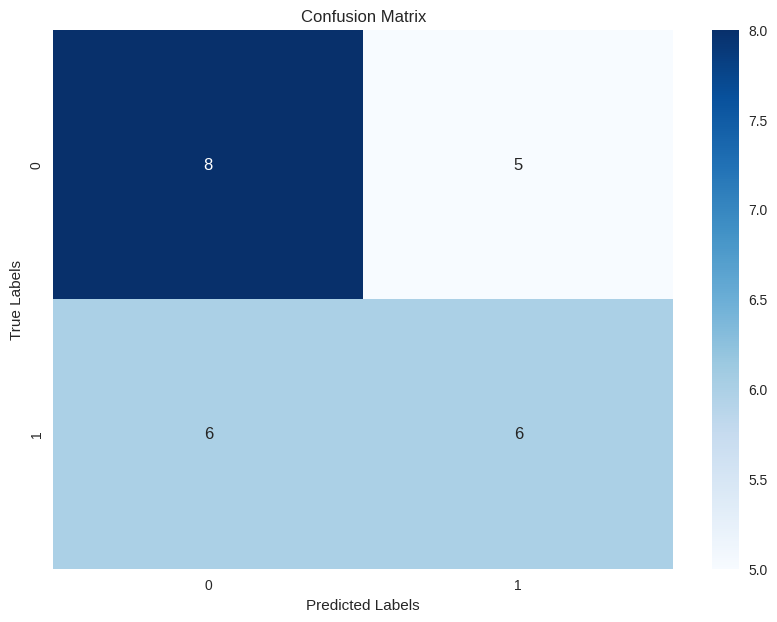

Accuracy: 0.56
Kappa: 0.11575562700964626
Classification Report:
              precision    recall  f1-score   support

    Accepted       0.57      0.62      0.59        13
    Rejected       0.55      0.50      0.52        12

    accuracy                           0.56        25
   macro avg       0.56      0.56      0.56        25
weighted avg       0.56      0.56      0.56        25



In [10]:
# Assuming test_predictions['prediction_label'] contains your predicted labels
predicted_labels = test_predictions['prediction_label']
true_labels = df_test['Admission Status']  # Assuming 'Admission Status' is your target column

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calcular métricas
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels)

print(f'Accuracy: {accuracy}')
print(f'Kappa: {kappa}')
print('Classification Report:')
print(classification_rep)


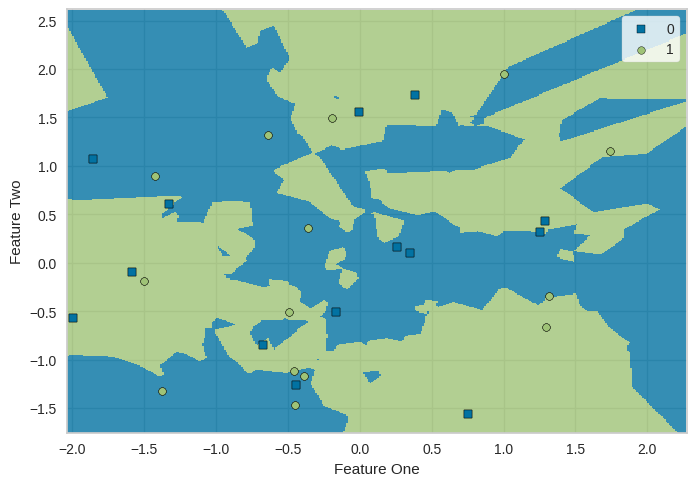

In [11]:
# Visualizando o modelo
graph1 = plot_model(knn_model, plot='boundary')

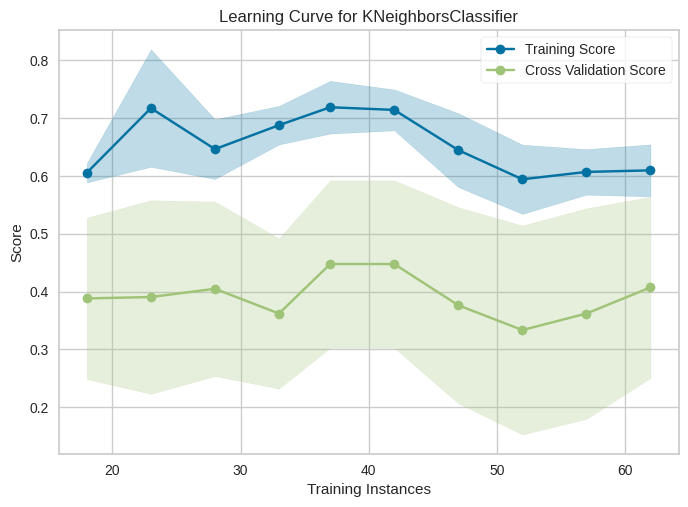

In [12]:
# Visualizando o modelo
graph2 = plot_model(knn_model, plot='learning')
